In [62]:
import os
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.tree import export_graphviz
%matplotlib inline

In [2]:
train_df = pd.read_csv(os.path.join("input",'train.csv'), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

In [6]:
train_df.shape

(629145480, 2)

In [7]:
rows = 150000
segments = int(np.floor(train_df.shape[0] / rows))
print("Number of segments: ", segments)

Number of segments:  4194


In [10]:
train_X = pd.DataFrame(index=range(segments), dtype=np.float64)
train_y = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

In [60]:
def create_features(seg_id,seg, X):
    xc = seg["acoustic_data"]

    X.loc[seg_id,"avg"] = xc.mean()
    X.loc[seg_id,"max"] = xc.max()
    X.loc[seg_id,"min"] = xc.min()
    X.loc[seg_id,"skew"] = xc.skew()
    X.loc[seg_id,"kurt"] = xc.kurt()
    X.loc[seg_id,"median"] = xc.median()

In [61]:
for seg_id in tqdm_notebook(range(segments)):
    seg = train_df.iloc[seg_id*rows:seg_id*rows+rows]
    create_features(seg_id, seg,train_X)
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

In [39]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

In [92]:
tree_clf = DecisionTreeRegressor(max_depth=8)

In [96]:
features_importance = pd.DataFrame({"features":train_X.columns,
                                    "importance":np.zeros(train_X.columns.shape[0])})
for train_idx,val_idx in folds.split(train_X,train_y):
    X_train,y_train = train_X.iloc[train_idx],train_y.iloc[train_idx]
    X_val,y_val = train_X.iloc[val_idx],train_y.iloc[val_idx]
    
    tree_clf.fit(X_train,y_train)
    preds = tree_clf.predict(X_val)
    
    features_importance["importance"] += tree_clf.feature_importances_
    
    print("MAE_val = {}".format(mean_absolute_error(y_val,preds)))

MAE_val = 2.558528182883674
MAE_val = 2.516195604871095
MAE_val = 2.509421759883831
MAE_val = 2.474525593644704
MAE_val = 2.4906250324465304


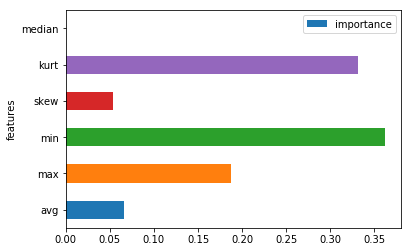

In [97]:
features_importance["importance"] = features_importance["importance"]/5
features_importance.plot(kind='barh',x="features",y="importance")

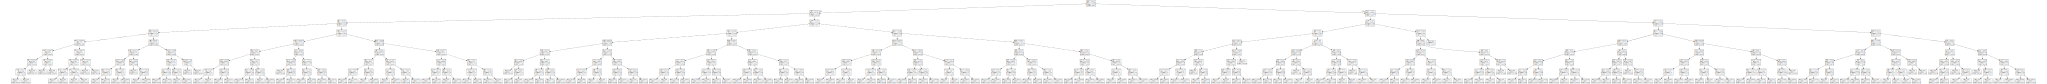

In [98]:
import graphviz
from IPython.display import display

dot_data = export_graphviz(tree_clf,out_file=None,feature_names=train_X.columns )
graph = graphviz.Source(dot_data)
display(graph)